# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;                        Projeto 3 - Ciência dos Dados
___
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; **André Nadalini, Guilherme Lotaif, João Zsigmiond e Kamila Wansa**

<br>

## 1. Problema: Análise de dados de lutas da UFC


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Este projeto tem como objetivo principal a análise de dados com grau elevado de autonomia. Para fazer a mesma, pegamos nossa base de dados através do site [kaggle](https://www.kaggle.com), que contém diferentes datasets com conteúdos variados. 

Por meio da análise de dados, pretendemos responder à pergunta:
#### Dado dois jogadores e suas características, quem tem a maior chance de ganhar a luta?

___


### 1.1. Preparação para a análise:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para efetuarmos o estudo, temos que abrir e corrigir possíveis problemas que podem atrapalhar nossa análise. Com isso em mente vamos primeiro arrumar as colunas categóricas.

**Importando as bibliotecas**

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from matplotlib import pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


plt.style.use('ggplot')

**Importando as bases de dados**

In [3]:
#Importando o arquivo de treinamento:
data = pd.read_csv("./ufcdata/data.csv")

In [4]:
#Vamos ver um exemplo do nosso dataframe:
data.head(2)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0


...
<br>

Para evitar erros no codigo vamos averiguar por possíveis dados nulos, que caso existam terão que ser eliminados. 

In [5]:
dados_nulos = data.isnull().sum().sum()
print("O dataset possui um total de {0} valores nulos.".format(dados_nulos))

O dataset possui um total de 95390 valores nulos.


In [6]:
#Vamos eliminar os dados nulos:
data.dropna(inplace=True)
data = data.truncate(0, 3500)

...
<br>

#### Corrigindo itens na tabela:<br>

Para fazermos a análise e o classificador de maneira mais eficaz temos que corrigir pequenos problemas que poderão nos atrapalhar no futuro, portanto vamos criar colunas novas com parte dos dados coletados de outras colunas categóricas.


In [7]:
#Criando uma coluna para os países extraídos da coluna de localização:
data['country'] = data['location'].apply(lambda x : x.split(',')[-1])

#Criando uma coluna com os anos extraídos da coluna de data:
data['year'] = data['date'].apply(lambda x : x.split('-')[0])

<br>

Agora vamos separar o lutador perdedor do vencedor.

In [8]:
#Vamos Criar um dataframe para as vitorias de "Red" e "Blue":
red_wins_data = data.loc[data.Winner == "Red"]
red_lose_data = data.loc[data.Winner == "Blue"]

...


#### Vamos criar um dataframe relativo

Para fazer a classificação, decidimos fazer um dataframe relativo uma vez que este analisa os dados, já que com ele, saberemos a relação entre os dois jogadores para uma mesma variável qualitativa. Com isso, a função ***get_relevant_dictionary***, cria um dicionário onde as chaves são os nomes das colunas cujos valores pertencem ao lutador "R", e os valores são as colunas cujos valores pertencem ao lutador "B". 

Ex.: { "R_fighter" : "B_fighter" }. 

Já a função ***create_relative_df*** cria um novo dataframe, no qual as colunas são as variáveis quantitativas, e as linhas são a razão entre os valores do lutador do foo <font color='red'>RED corner</font> foo pelo do lutador do foo <font color='blue'>BLUE corner</font>. 

In [9]:
def get_relevant_dictionary(df):
    dic = {}
    colunas = df.columns.values;
    for name in colunas:
        if name[0] == "R" and name != "Referee":
            oposer_name = "B"+name[1:]
            dic[name] = oposer_name
    return(dic)

In [10]:
data_preprocessed = pd.read_csv("./ufcdata/preprocessed_data.csv")
data_preprocessed["win"] = 0
data_preprocessed.loc[data_preprocessed.Winner == "Red", "win"] = 1

wins = data_preprocessed["win"]

In [38]:
def create_relative_df(data, relevant_categories):
    dic = {}
    for R_value, B_value in relevant_categories.items():
        if type(data[R_value].iloc[1]) == np.float64:
            dic["{}".format(R_value[2:])] = (data[R_value] - data[B_value]/ data[B_value])
    relative_df = pd.DataFrame(dic)
    return relative_df


relevant_categories = get_relevant_dictionary(data_preprocessed)
relative_df = create_relative_df(data_preprocessed, relevant_categories)

relative_df["win"] = wins

relative_df.drop(columns= ["current_lose_streak","draw"], inplace = True)
relative_df.head(2)

,current_win_streak,avg_BODY_att,avg_BODY_landed,avg_CLINCH_att,avg_CLINCH_landed,avg_DISTANCE_att,avg_DISTANCE_landed,avg_GROUND_att,avg_GROUND_landed,avg_HEAD_att,...,win_by_Decision_Unanimous,win_by_KO/TKO,win_by_Submission,win_by_TKO_Doctor_Stoppage,wins,Height_cms,Reach_cms,Weight_lbs,age,win
0,3.0,20.9,15.400000,16.000000,NaN,74.000000,25.500000,8.400000,5.500000,73.200000,...,NaN,1.0,-1.0,NaN,7.0,161.56,161.56,134.0,31.0,1
1,1.0,11.0,6.714286,8.285714,5.857143,87.142857,35.142857,17.428571,15.428571,83.571429,...,1.0,NaN,NaN,-1.0,4.0,164.10,166.64,124.0,30.0,1


In [12]:
relative_total_rounds = np.array(relative_df['total_rounds_fought'])
relative_total_rounds = relative_total_rounds.reshape(-1, 1)

___
<br>

## 2. Análise Exploratória:

Para que possamos definir quais colunas de características são as mais importantes para a implementação do metodo de predição, temos que analisar os dados no dataframe e discutir a importância de seus resultados.


...
<br>

**Quantas disputas registradas são por títulos?**<br>
Para sabermos a importância de cada luta, é importante saber se existem muitas lutas com disputa por títulos, ou se estas ocorrem com menor frequência.

In [76]:
#Vamos descobrir a quantidade:
bout_ = red_wins_data.title_bout.value_counts()

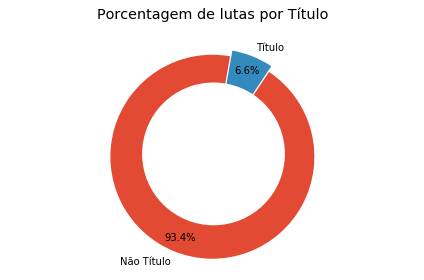

In [77]:
# Vamos nomear as partes:
labels = ['Não Título', 'Título']
sizes = bout_.values
# Vamos "explodir" somente um pedaço:
explode = (0.03,0.03)
#Fornecendo as caracteristicas do gráfico:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=80,
        pctdistance=0.85, explode = explode)
#Criando o Círculo:
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Vamos definir o aspecto de circulo, portanto "equal":
ax1.axis('equal')
plt.title("Porcentagem de lutas por Título\n")
plt.tight_layout()
plt.show()

...
<br>

**Qual será o número de rounds que as lutas duram?**

In [15]:
#Vamos descobrir a quantidade:
total_rounds = data_preprocessed['no_of_rounds'].value_counts().sort_index()

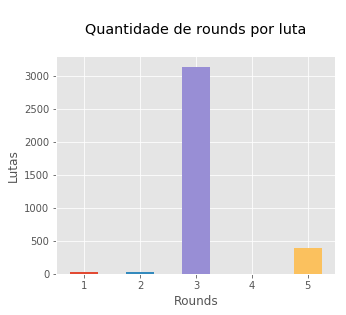

In [16]:
#Criando uma tabela com os dados:)
plot = total_rounds.plot(kind='bar', figsize=(5, 4), align='center')
plt.title("\nQuantidade de rounds por luta\n")
plt.xticks(rotation=0)
plt.ylabel('Lutas')
plt.xlabel('Rounds')
plt.show()

...
<br>

**Qual time será que possui mais vitórias?**

Lembrando que foi usada a divisão do banco de dados dos lutadores como "Blue" e "Red".

In [17]:
#Vamos descobrir a quantidade:
winner_1 = data.Winner.value_counts()

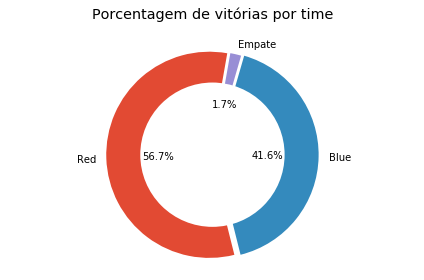

In [18]:
# Vamos nomear as partes:
labels = ['Red', 'Blue',"Empate"]
sizes = winner_1.values
# Vamos "explodir" somente um pedaço:
explode = (0.03,0.03,0)
#Fornecendo as caracteristicas do gráfico:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=80,
        pctdistance=0.50, explode = explode)
#Criando o Círculo:
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Vamos definir o aspecto de circulo, portanto "equal":
ax1.axis('equal')
plt.title("Porcentagem de vitórias por time\n")
plt.tight_layout()
plt.show()

...
<br>

**Será que existe um país qu as lutas ocorrem mais vezes?**

In [19]:
#Vamos descobrir a quantidade:
loc_1 = data.country.value_counts().head(15)

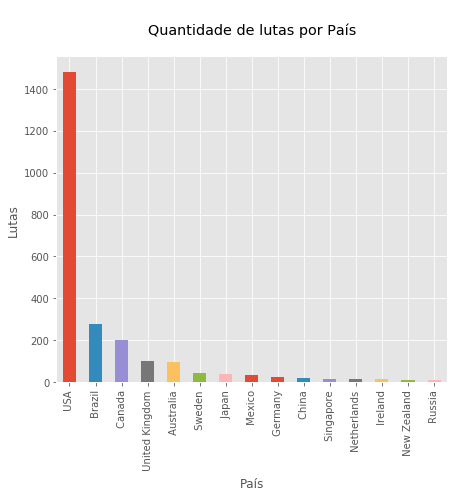

In [20]:
#Criando uma tabela com os dados:)
plot = loc_1.plot(kind='bar', figsize=(7, 6), align='center')
plt.title("\nQuantidade de lutas por País\n")
plt.xticks(rotation=90)
plt.ylabel('Lutas')
plt.xlabel('País')
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.10524067007669329

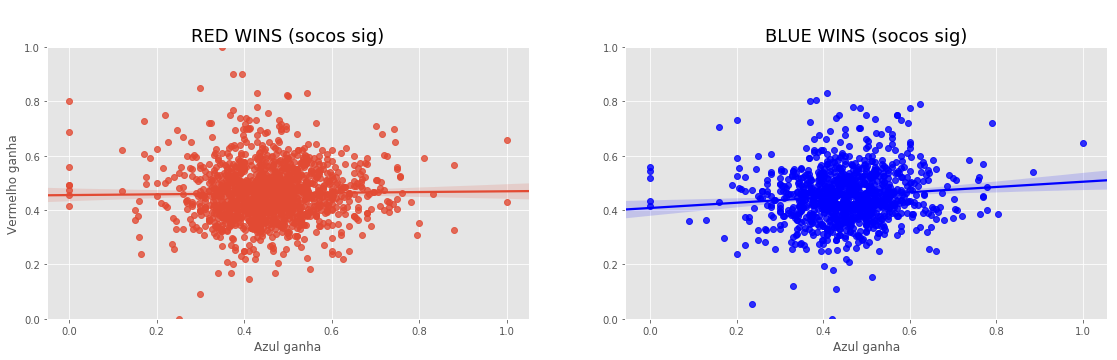

In [21]:
fig = plt.figure(figsize=(19, 5))
plt.subplot(121)
ax0 = sns.regplot(x=red_wins_data.B_avg_SIG_STR_pct, y=red_wins_data.R_avg_SIG_STR_pct,
                      data=data)
plt.title("\nRED WINS (socos sig)",size=18)
plt.ylabel('Vermelho ganha')
plt.xlabel('Azul ganha')
ax0.set(ylim=(0,1))

plt.subplot(122)
ax1 = sns.regplot(x=red_lose_data.B_avg_SIG_STR_pct, y=red_lose_data.R_avg_SIG_STR_pct,color="blue",
                      data=data)
plt.title("\nBLUE WINS (socos sig)",size=18)
plt.ylabel('')
plt.xlabel('Azul ganha')
ax1.set(ylim=(0,1))

red_lose_data.B_avg_SIG_STR_pct.corr(red_lose_data.R_avg_SIG_STR_pct)

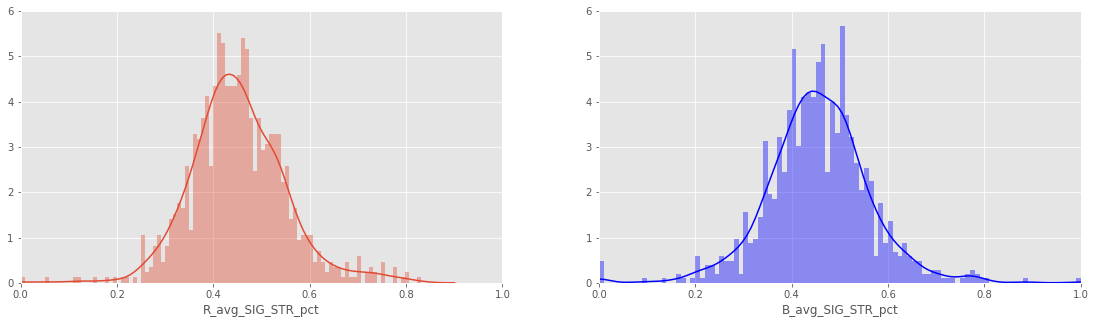

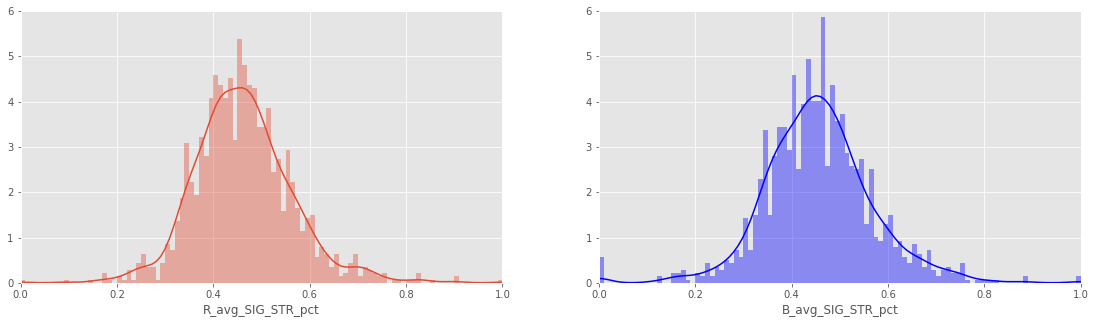

In [22]:
fig = plt.figure(figsize=(19, 5))
plt.subplot(121)
ax2 = sns.distplot(red_lose_data.R_avg_SIG_STR_pct, bins = 100)
ax2.set(xlim=(0,1))
ax2.set(ylim=(0,6))
plt.subplot(122)
ax2 = sns.distplot(red_lose_data.B_avg_SIG_STR_pct, bins = 100, color="b")
ax2.set(xlim=(0,1))
ax2.set(ylim=(0,6))
plt.show()
fig = plt.figure(figsize=(19, 5))
plt.subplot(121)
ax2 = sns.distplot(red_wins_data.R_avg_SIG_STR_pct, bins = 100)
ax2.set(xlim=(0,1))
ax2.set(ylim=(0,6))
plt.subplot(122)
ax2 = sns.distplot(red_wins_data.B_avg_SIG_STR_pct, bins = 100, color="b")
ax2.set(xlim=(0,1))
ax2.set(ylim=(0,6))
plt.show()

Text(0, 0.5, '')

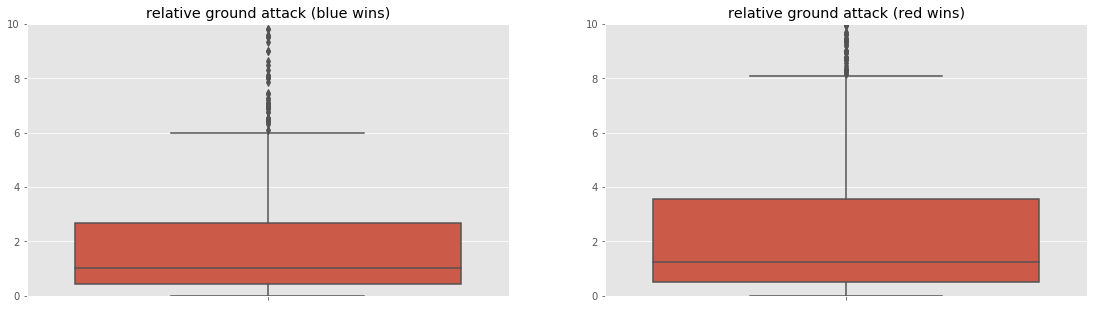

In [23]:
fig = plt.figure(figsize=(19, 5))
plt.subplot(121)
ax = sns.boxplot(y=relative_df.avg_GROUND_att.loc[relative_df.win== 0])
ax.set(ylim=(0,10))
plt.title("relative ground attack (blue wins)")
plt.ylabel("")

plt.subplot(122)
ax = sns.boxplot(y=relative_df.avg_GROUND_att.loc[relative_df.win== 1])
ax.set(ylim=(0,10))
plt.title("relative ground attack (red wins)")
plt.ylabel("")

Text(0, 0.5, '')

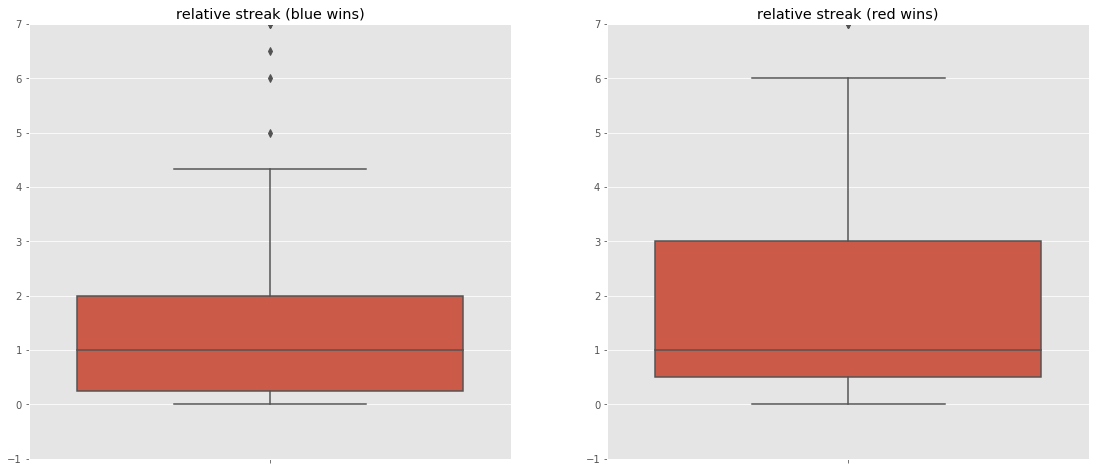

In [24]:
fig = plt.figure(figsize=(19, 8))
plt.subplot(121)
ax = sns.boxplot(y=relative_df.current_win_streak.loc[relative_df.win == 0])
ax.set(ylim=(-1,7))
plt.title("relative streak (blue wins)")
plt.ylabel("")

plt.subplot(122)
ax = sns.boxplot(y=relative_df.current_win_streak.loc[relative_df.win== 1])
ax.set(ylim=(-1,7))
plt.title("relative streak (red wins)")
plt.ylabel("")

Text(0, 0.5, '')

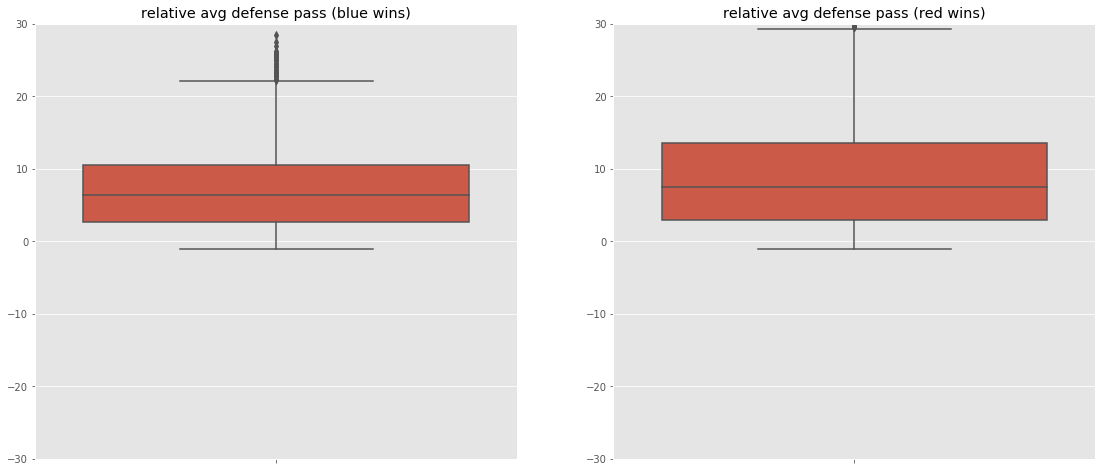

In [39]:
fig = plt.figure(figsize=(19, 8))
plt.subplot(121)
ax = sns.boxplot(y=relative_df.avg_GROUND_att.loc[relative_df.win == 0])
ax.set(ylim=(-30,30))
plt.title("relative avg defense pass (blue wins)")
plt.ylabel("")

plt.subplot(122)
ax = sns.boxplot(y=relative_df.avg_GROUND_att.loc[relative_df.win== 1])
ax.set(ylim=(-30,30))
plt.title("relative avg defense pass (red wins)")
plt.ylabel("")

Text(0, 0.5, '')

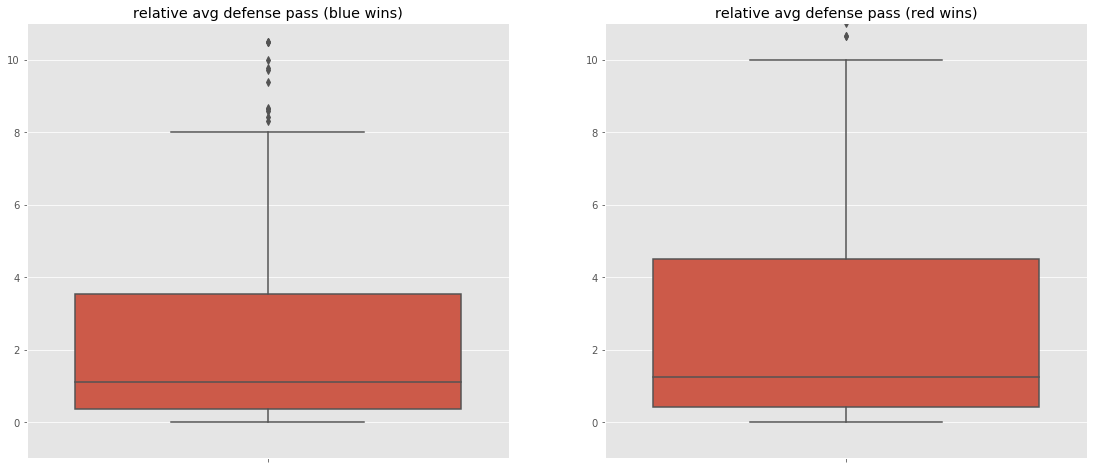

In [26]:
fig = plt.figure(figsize=(19, 8))
plt.subplot(121)
ax = sns.boxplot(y=relative_df.avg_PASS.loc[relative_df.win == 0])
ax.set(ylim=(-1,11))
plt.title("relative avg defense pass (blue wins)")
plt.ylabel("")

plt.subplot(122)
ax = sns.boxplot(y=relative_df.avg_PASS.loc[relative_df.win== 1])
ax.set(ylim=(-1,11))
plt.title("relative avg defense pass (red wins)")
plt.ylabel("")

Text(0, 0.5, '')

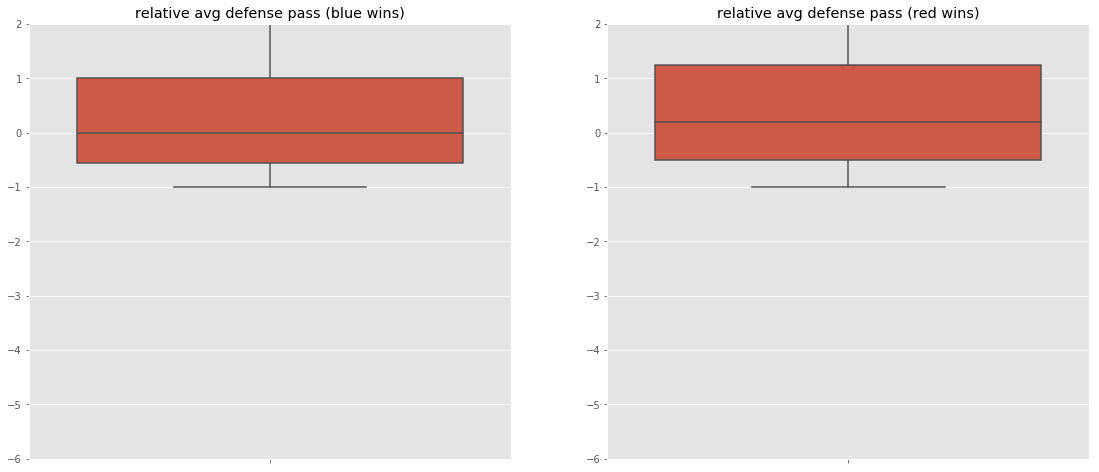

In [41]:
fig = plt.figure(figsize=(19, 8))
plt.subplot(121)
ax = sns.boxplot(y=relative_df.avg_PASS.loc[relative_df.win == 0])
ax.set(ylim=(-6,2))
plt.title("relative avg defense pass (blue wins)")
plt.ylabel("")

plt.subplot(122)
ax = sns.boxplot(y=relative_df.avg_PASS.loc[relative_df.win== 1])
ax.set(ylim=(-6,2))
plt.title("relative avg defense pass (red wins)")
plt.ylabel("")

Text(0, 0.5, '')

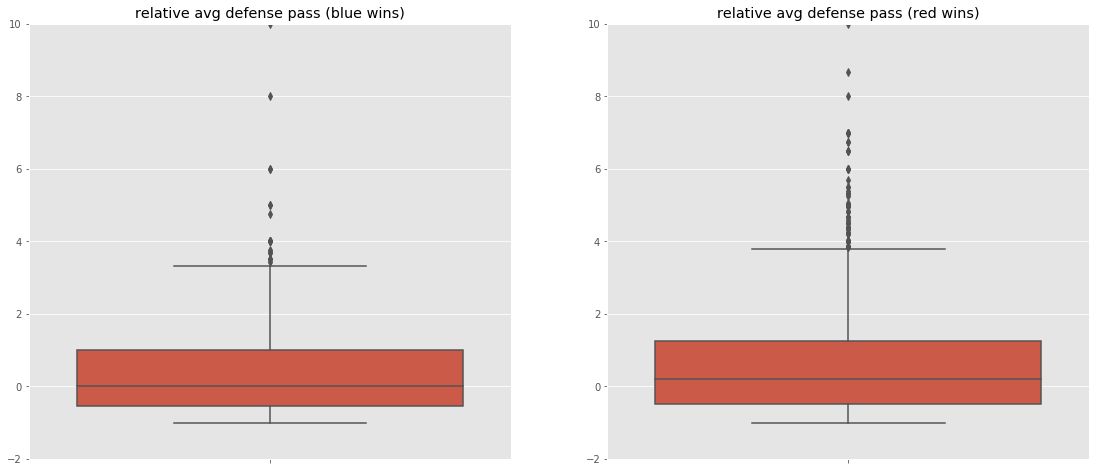

In [42]:
fig = plt.figure(figsize=(19, 8))
plt.subplot(121)
ax = sns.boxplot(y=relative_df.avg_PASS.loc[relative_df.win == 0])
ax.set(ylim=(-2,10))
plt.title("relative avg defense pass (blue wins)")
plt.ylabel("")

plt.subplot(122)
ax = sns.boxplot(y=relative_df.avg_PASS.loc[relative_df.win== 1])
ax.set(ylim=(-2,10))
plt.title("relative avg defense pass (red wins)")
plt.ylabel("")

0.13137793473333023

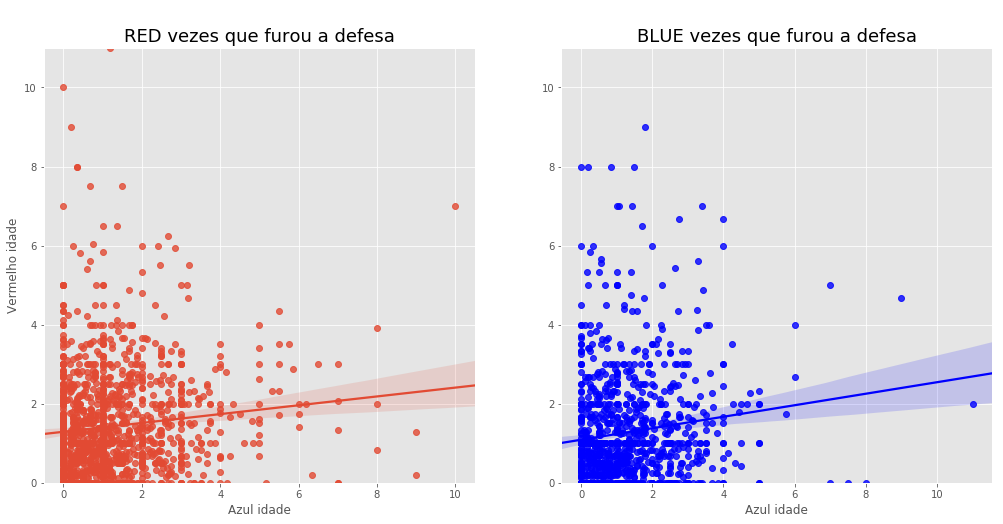

In [43]:
fig = plt.figure(figsize=(17, 8))
plt.subplot(121)
ax0 = sns.regplot(x=red_wins_data.B_avg_PASS, y=red_wins_data.R_avg_PASS,
                      data=red_wins_data)
plt.title("\nRED vezes que furou a defesa",size=18)
plt.ylabel('Vermelho idade')
plt.xlabel('Azul idade')
ax0.set(ylim=(0,11))

plt.subplot(122)
ax1 = sns.regplot(x=red_lose_data.R_avg_PASS, y=red_lose_data.B_avg_PASS,color="blue",
                      data=red_lose_data)
plt.title("\nBLUE vezes que furou a defesa",size=18)
plt.ylabel('')
plt.xlabel('Azul idade')
ax1.set(ylim=(0,11))

red_lose_data.R_avg_PASS.corr(red_lose_data.B_avg_PASS)

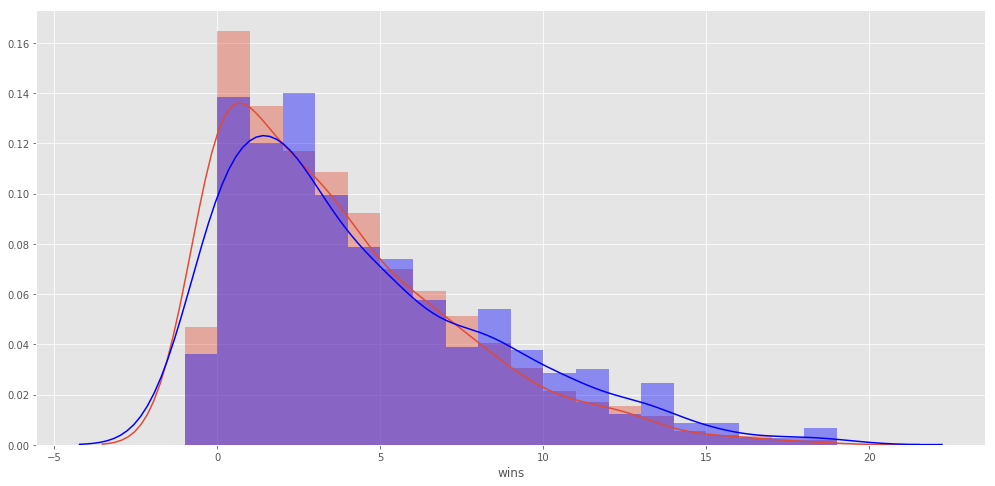

In [48]:
relative_df = relative_df.replace([np.inf, -np.inf], np.nan)
relative_df.avg_SIG_STR_pct.dropna(inplace=True)

fig = plt.figure(figsize=(17, 8))
ax2 = sns.distplot(relative_df.wins.loc[data_preprocessed.Winner == "Red"], bins = 20);
ax3 = sns.distplot(relative_df.wins.loc[data_preprocessed.Winner == "Blue"], bins = 20, color = "b");
#ax2.set(xlim=(0,4))

0.18160219940128505

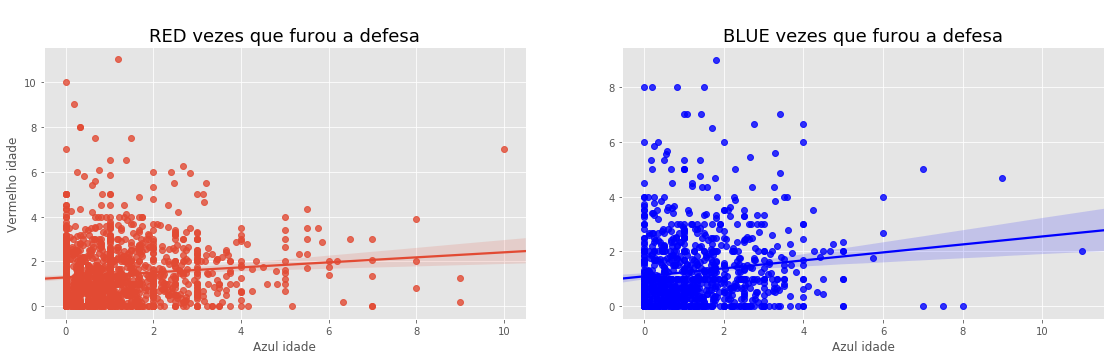

In [49]:
fig = plt.figure(figsize=(19, 5))
plt.subplot(121)
ax0 = sns.regplot(x=red_wins_data.B_avg_PASS, y=red_wins_data.R_avg_PASS,
                      data=red_wins_data)
plt.title("\nRED vezes que furou a defesa",size=18)
plt.ylabel('Vermelho idade')
plt.xlabel('Azul idade')
#ax0.set(ylim=(0,1))

plt.subplot(122)
ax1 = sns.regplot(x=red_lose_data.R_avg_PASS, y=red_lose_data.B_avg_PASS,color="blue",
                      data=red_lose_data)
plt.title("\nBLUE vezes que furou a defesa",size=18)
plt.ylabel('')
plt.xlabel('Azul idade')
#ax1.set(ylim=(0,1))

red_lose_data.B_age.corr(red_lose_data.R_age)

...


### • Análise pelo Pandas Profiling:

Esta função normalmente é usada quando queremos fazer uma análise exploratória um pouco mais completa e de maneira rapida e intuitiva. Tal método funciona de maneira que quando a função é chamada, ela cria uma análise dos dados do Dataframe através do pandas.

A ferramenta requer uma intalação:

**PIP INSTALL**<br>
Para instalar através do PIP, use o comando:

`pip install pandas-profiling`

**CONDA INSTALL**<br>
Para isntalar através do Conda, use o comando:

`conda install -c anaconda pandas-profiling`

<br>

In [55]:
import pandas_profiling

ModuleNotFoundError: No module named 'pandas_profiling'

In [56]:
pandas_profiling.ProfileReport(data)

NameError: name 'pandas_profiling' is not defined

___
<br>

## 3. Implementação dos metodos de predição.

<br>
Primeiro Vamos organizar o dataframe da melhor maneira para termos o melhor resultado possível.

In [57]:
win = np.array(relative_df["win"])
win = win.ravel()

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
        relative_total_rounds, win, test_size=0.33, random_state=42)

...
<br><br>

**`Classificador KNN:`**

In [59]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [60]:
knn_y_pred = knn.predict(X_test)

In [61]:
metrics.accuracy_score(y_test, knn_y_pred)

0.6205733558178752

...
<br><br>

**`Classificador GNB:`**

In [62]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [63]:
gnb_y_pred = gnb.predict(X_test)
metrics.accuracy_score(y_test, gnb_y_pred)

0.6652613827993255

...
<br><br>

**`Classificador Random Forest:`**

In [66]:
rfst = RandomForestClassifier()
rfst.fit(X_train, y_train);

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [67]:
rfst_y_pred = rfst.predict(X_test)
metrics.accuracy_score(y_test, rfst_y_pred)

0.6045531197301856

...
<br><br>

**`Classificador MLP:`**

In [68]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp_y_pred = mlp.predict(X_test)
metrics.accuracy_score(y_test, mlp_y_pred)

0.6669477234401349

___
<br>

## 4. Conclusão:

O nosso dataframe não possuia diversas informações importantes para avaliar o desempenho de cada jogador, como por exemplo o incentivo financeiro, o local da luta (se foi no local de nascimento de um dos jogadores). Além disso, como estamos analisando valores relativos entre dois lutadores, de forma que as características em questão são semelhantes, muitas vezes pode acontecer de serem valores bastante próximos, reduzindo assim a variabilidade, quando se tratando de apenas poucas variáveis. Por outro lado, quando analisamos muitas variáveis, que é o caso do nosso datasheet, pode ser possível perceber uma maior variação do conjunto de forma a prever com maior acurácia o resultado.

___
<br>

## 5. Referências Bibliográficas:

- https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f